In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process.kernels import Matern, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel
from SALib.analyze import sobol
from scipy.stats import qmc
import joblib

In [109]:
df = pd.read_csv(r'plate.csv')

In [110]:
df

,Fib_Angle,Ply_Layers,E1/E2,Winkler,Pasternak,Rx,Ry,a/h,Skew_Angle,Poisson_R,Omega,Strat_cat
0,30.0,10,40.0,0.0,0.0,0.0,0.0,75.0,0.0,0.25,23.7693,EF0_Plate
1,60.0,6,90.0,0.0,0.0,0.0,0.0,25.0,15.0,0.25,31.0160,EF0_Plate
2,15.0,4,40.0,0.0,0.0,0.0,0.0,10.0,15.0,0.20,15.3482,EF0_Plate
3,15.0,8,25.0,0.0,0.0,0.0,0.0,5.0,5.0,0.25,10.4830,EF0_Plate
4,30.0,4,10.0,0.0,0.0,0.0,0.0,5.0,60.0,0.25,13.0508,EF0_Plate
...,...,...,...,...,...,...,...,...,...,...,...,...
9093,45.0,8,40.0,7500.0,2500.0,0.0,0.0,50.0,15.0,0.40,204.9894,EF3_Plate
9094,15.0,8,40.0,5000.0,1500.0,0.0,0.0,10.0,75.0,0.30,93.2725,EF3_Plate
9095,15.0,12,10.0,5000.0,500.0,0.0,0.0,5.0,60.0,0.25,59.4687,EF3_Plate
9096,30.0,4,40.0,2500.0,500.0,0.0,0.0,50.0,15.0,0.25,106.3438,EF3_Plate


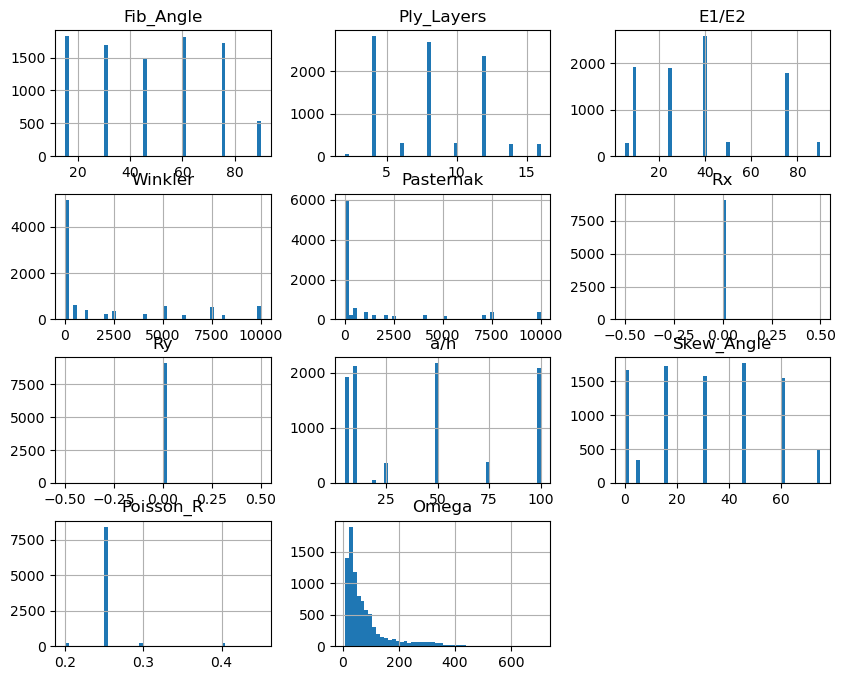

In [111]:
df.hist(bins=50, figsize=(10,8))
plt.show()

In [112]:
train_set, test_set = train_test_split(
    df, test_size=0.20, stratify=df['Strat_cat'],shuffle=True, random_state=42)


In [113]:
train_set.drop(['Strat_cat','Ry','Rx'],axis=1, inplace=True)
test_set.drop(['Strat_cat','Ry','Rx'],axis=1, inplace=True)

In [114]:
train_set

,Fib_Angle,Ply_Layers,E1/E2,Winkler,Pasternak,a/h,Skew_Angle,Poisson_R,Omega
8486,30.0,8,10.0,1000.0,100.0,50.0,30.0,0.25,56.9083
6629,30.0,4,10.0,500.0,50.0,50.0,15.0,0.25,39.1694
1586,75.0,8,5.0,0.0,0.0,5.0,15.0,0.25,7.9077
3000,45.0,4,75.0,4000.0,0.0,100.0,60.0,0.25,92.5166
5825,30.0,8,25.0,0.0,7000.0,5.0,45.0,0.25,37.5179
...,...,...,...,...,...,...,...,...,...
817,60.0,12,75.0,0.0,0.0,50.0,60.0,0.25,96.3889
5181,15.0,8,75.0,0.0,5.0,100.0,0.0,0.25,29.1129
3227,45.0,4,40.0,10000.0,0.0,10.0,45.0,0.25,79.6255
3229,45.0,4,10.0,1000.0,0.0,100.0,30.0,0.25,34.2998


In [115]:
X_train = train_set.iloc[:, :8].values
y_train = train_set.iloc[:, 8].values

X_test = test_set.iloc[:, :8].values
y_test = test_set.iloc[:, 8].values

In [116]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return np.log1p(X)
    
    def inverse_transform(self, X):
        return np.expm1(X)
    
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return None
        return [f"{name}_log" for name in input_features]

In [117]:
qt_x = QuantileTransformer(n_quantiles=10, random_state=0, output_distribution='normal')
qt_y = LogTransformer()

X_train_scaled = qt_x.fit_transform(X_train)
X_test_scaled = qt_x.transform(X_test)

y_train_scaled = qt_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = qt_y.transform(y_test.reshape(-1, 1)).flatten()

In [72]:
# from sklearn.pipeline import Pipeline
# kernel=(WhiteKernel(noise_level=0.6) + 1.0 * 
#         Matern(length_scale=10, length_scale_bounds=(1e-05, 100000.0), nu = 1.5))

# gpr = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=10,alpha=5e-9,random_state=42)

# model_cut = Pipeline([
#     ('QuantileTransformer', qt_x),
#     ('GPR', gpr)
# ])

# model_cut.fit(X_train, y_train_scaled)

In [128]:
# from sklearn.ensemble import RandomForestRegressor
# from SALib.analyze import sobol
# from scipy.stats import qmc
# from sklearn.pipeline import Pipeline

# rndm_frst = RandomForestRegressor(random_state=42)

# pipe = Pipeline([
#     ('quantile_transform', QuantileTransformer(output_distribution='normal')),
#     ('regressor', rndm_frst),
# ])

# pipe.fit(X_train, y_train_scaled)

In [118]:
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

def compute_score(y_true, y_pred):
    return {
        "R2": f"{r2_score(y_true, y_pred):.3f}",
        "MAE": f"{mean_absolute_error(y_true, y_pred):.3f}",
        "RMSE": f"{root_mean_squared_error(y_true, y_pred):.3f}",
    }

In [119]:
# 
model = joblib.load(r'model_plate_RT.pkl')

In [120]:
y_pred = model.predict(X_test)
compute_score(y_test_scaled, y_pred)

{'R2': '0.986', 'MAE': '0.068', 'RMSE': '0.101'}

In [123]:
train_X = train_set.iloc[:,:8]
train_X

,Fib_Angle,Ply_Layers,E1/E2,Winkler,Pasternak,a/h,Skew_Angle,Poisson_R
8486,30.0,8,10.0,1000.0,100.0,50.0,30.0,0.25
6629,30.0,4,10.0,500.0,50.0,50.0,15.0,0.25
1586,75.0,8,5.0,0.0,0.0,5.0,15.0,0.25
3000,45.0,4,75.0,4000.0,0.0,100.0,60.0,0.25
5825,30.0,8,25.0,0.0,7000.0,5.0,45.0,0.25
...,...,...,...,...,...,...,...,...
817,60.0,12,75.0,0.0,0.0,50.0,60.0,0.25
5181,15.0,8,75.0,0.0,5.0,100.0,0.0,0.25
3227,45.0,4,40.0,10000.0,0.0,10.0,45.0,0.25
3229,45.0,4,10.0,1000.0,0.0,100.0,30.0,0.25


In [124]:
scaled_X = pd.DataFrame(X_train_scaled, columns=train_X.columns)

In [125]:
scaled_X.describe()

,Fib_Angle,Ply_Layers,E1/E2,Winkler,Pasternak,a/h,Skew_Angle,Poisson_R
count,7278.000000,7278.000000,7278.000000,7278.000000,7278.000000,7278.000000,7278.000000,7278.000000
mean,-0.628198,0.139527,0.038628,-2.186794,-1.868429,0.063848,-0.510596,-0.026119
std,2.626947,1.266750,1.485470,3.402694,3.222341,3.461568,2.538077,0.891242
min,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338
25%,-0.589456,-0.967422,-0.282216,-5.199338,-5.199338,-0.430727,-0.589456,0.000000
50%,-0.139710,0.000000,0.282216,-5.199338,-0.083652,0.282216,0.000000,0.000000
75%,0.282216,0.967422,0.519841,0.674490,0.764710,0.589456,0.589456,0.000000
max,5.199338,5.199338,5.199338,5.199338,5.199338,5.199338,5.199338,5.199338


### Sensitivity Analysis

In [61]:
train_set.columns.to_list()

['Fib_Angle',
 'Ply_Layers',
 'E1/E2',
 'Winkler',
 'Pasternak',
 'Rx',
 'Ry',
 'a/h',
 'Skew_Angle',
 'Poisson_R',
 'Omega']

In [126]:
list = ['Fiber\nAngle',
 'Ply\nLayers',
 '$E_1/E_2$',
 'Winkler\nStiffness',
 'Pasternak\nStiffness',
 'a/h',
 'Skew\nAngle',
 "Poisson's\nRatio"]

In [ ]:
# list = ['Fiber\nAngle',
#  'Ply\nLayers',
#  '$E_1/E_2$',
#  'Winkler\nStiffness',
#  'Pasternak\nStiffness',
#  '$R_x$',
#  '$R_y$',
#  'a/h',
#  'Skew\nAngle',
#  "Poisson's\nRatio"]

In [127]:
len(list)

8

In [128]:
problem = {
    'num_vars':8,
    'names': list,
    'bounds':[[-5.199338, 5.199338]*8]
    
}
# 'bounds': [
#         [15, 75], [2, 8], [5, 50], [0, 7000], [0, 9000],
#         [0,1], [5, 100], [0, 75], [0.2, 0.45]
#     ]

In [129]:
from SALib.sample import sobol

N = 4096  # Base sample size, increase for higher accuracy
param_values = sobol.sample(problem, N, calc_second_order=True)

In [25]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# scaler.fit(X_train)


In [26]:
# scaler_y = MinMaxScaler()
# scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()

In [130]:
param_values = qt_x.inverse_transform(param_values)

In [131]:
Y = model.predict(param_values)

In [132]:
Y

array([6.18839457, 6.08271098, 6.27949725, ..., 3.30194967, 3.64129934,
       3.51310796])

In [133]:
# y_pred_S = qt_y.inverse_transform(Y.reshape(-1,1)).flatten()
y_pred_S = Y

In [134]:
y_pred_S

array([6.18839457, 6.08271098, 6.27949725, ..., 3.30194967, 3.64129934,
       3.51310796])

In [135]:
from SALib.analyze import sobol
Si = sobol.analyze(problem, y_pred_S, calc_second_order=True, print_to_console=True)

# 5. Access results
print("First-order indices:", Si['S1'])
print("Total-order indices:", Si['ST'])

c:\Users\Sabyasachi\.conda\envs\DSML\lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


                            ST   ST_conf
Fiber\nAngle          0.055303  0.004944
Ply\nLayers           0.026332  0.001922
$E_1/E_2$             0.148856  0.009327
Winkler\nStiffness    0.217009  0.016015
Pasternak\nStiffness  0.348430  0.020747
a/h                   0.371270  0.020103
Skew\nAngle           0.160131  0.013123
Poisson's\nRatio      0.033800  0.002163
                            S1   S1_conf
Fiber\nAngle          0.010319  0.009335
Ply\nLayers           0.003987  0.007864
$E_1/E_2$             0.098372  0.014796
Winkler\nStiffness    0.121168  0.021240
Pasternak\nStiffness  0.202853  0.023758
a/h                   0.264776  0.023588
Skew\nAngle           0.035944  0.014792
Poisson's\nRatio     -0.006387  0.007739
                                                  S2   S2_conf
(Fiber\nAngle, Ply\nLayers)                -0.003506  0.014125
(Fiber\nAngle, $E_1/E_2$)                  -0.003094  0.014285
(Fiber\nAngle, Winkler\nStiffness)         -0.007137  0.014955
(Fiber\nAn

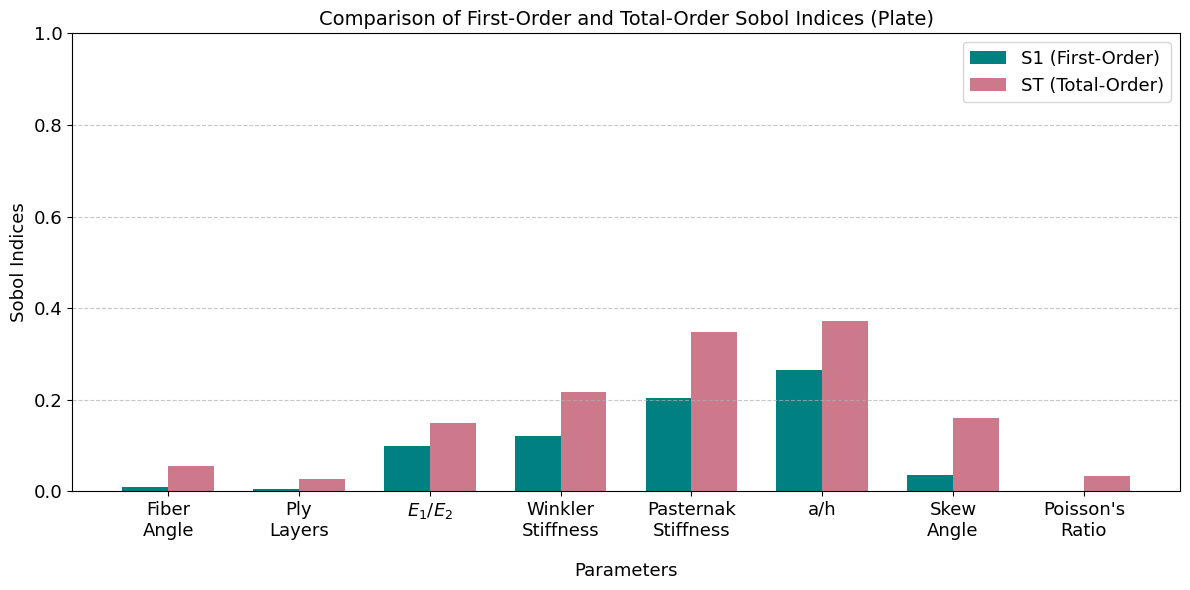

In [140]:
x = np.arange(len(problem['names']))  # Parameter indices
width = 0.35  # Bar width

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, Si['S1'], width, label='S1 (First-Order)', color='teal')
bars2 = ax.bar(x + width/2, Si['ST'], width, label='ST (Total-Order)', color='xkcd:dusky pink')

ax.set_xlabel('Parameters',fontdict={'fontsize':13},labelpad=16)
ax.set_ylabel('Sobol Indices',fontdict={'fontsize':13})
ax.set_title('Comparison of First-Order and Total-Order Sobol Indices (Plate)'
             ,fontdict={'fontsize':14})
ax.set_xticks(x)
ax.set_xticklabels(problem['names'])
ax.tick_params(axis='both', which='major', labelsize=13)
ax.legend(fontsize=13)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.ylim(0, 1)
plt.tight_layout()
# plt.savefig("Plate S1 and ST.png")
plt.show()

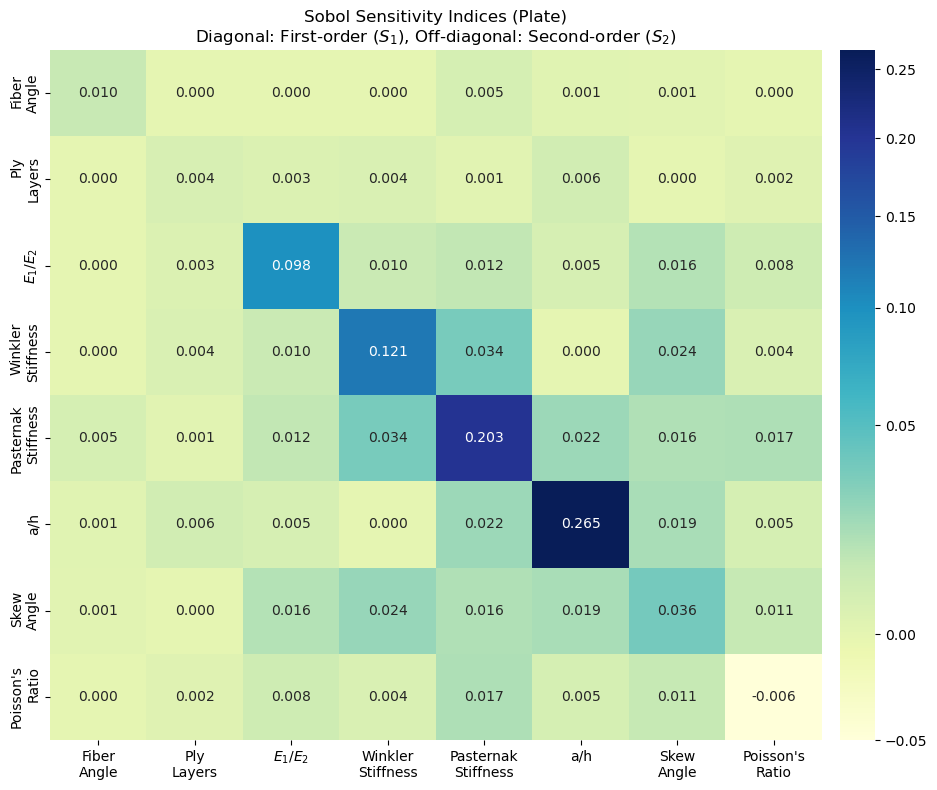

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import PowerNorm

def plot_sobol_heatmap(Si, param_names):
    # Extract indices
    S1 = Si['S1']
    S2 = Si['S2']
    S2[S2 < 0.001] = 0
    # Create a matrix for the heatmap
    n_params = len(param_names)
    heatmap_matrix = np.zeros((n_params, n_params))
    
    # Fill diagonal with first-order indices
    for i in range(n_params):
        heatmap_matrix[i, i] = S1[i]
    
    # Fill off-diagonal with second-order indices
    for i in range(n_params):
        for j in range(i+1, n_params):
            heatmap_matrix[i, j] = S2[i, j]
            heatmap_matrix[j, i] = S2[i, j]  # Mirror the matrix
    
    # Create the heatmap
    plt.figure(figsize=(10, 8))
    mask = np.zeros_like(heatmap_matrix, dtype=bool)
    mask[np.tril_indices_from(mask, k=-1)] = False  # Optional: mask lower triangle
    
    ax = sns.heatmap(heatmap_matrix, annot=True, fmt='.3f', 
                    xticklabels=param_names, yticklabels=param_names,
                    norm=PowerNorm(gamma=0.5),cmap='YlGnBu', mask=mask,
                    cbar_kws={'pad': 0.02})
    
    plt.title('Sobol Sensitivity Indices (Plate)\nDiagonal: First-order ($S_1$), Off-diagonal: Second-order ($S_2$)'
              , fontdict={'fontsize':12})
    plt.tick_params(axis='both', which='major', labelsize=10)
    
 
    
    return ax

# Example usage
plot_sobol_heatmap(Si, problem['names'])

plt.tight_layout()
# plt.savefig("Plate S1 and S2.png", bbox_inches='tight', pad_inches=0.05)
plt.show()